In [2]:
%matplotlib inline
%load_ext autoreload
from __future__ import print_function
import matplotlib.pyplot as plt
from nb_utils import basemodel
from drivers.chainer.trainer import Trainer
from utils import parse_json
import time
import copy
import json

In [3]:
import ipyparallel as ipp
clients = ipp.Client()
clients.block = True
clients.ids
view = clients.load_balanced_view()
dview = clients[:]

In [4]:
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

In [5]:
from engines import v1_0_0
mp = load_json("/project/exp/list_mp.pips.json")
mp['config'] = v1_0_0.config

In [6]:
mp['config']

{'align': 200,
 'basemodel': 'nlstm2_nobias_13500iters',
 'batch_size': 260,
 'dropout_ratio': 0.5,
 'extend_ohlc': True,
 'iters': 600,
 'large_forget_gate_bias': True,
 'n_lstm': 2,
 'n_units': 250,
 'random_seed': 151,
 'use_pips': True,
 'use_sigmoid': True}

In [7]:
dataset = parse_json(load_json("/project/exp/list.json"))

In [8]:
def status_hook(i, l):
    if i % 10 == 0:
        print("[{0}] Loss={1}".format(i + 1, l))

def logging_hook(i, train_dots, test_dots, train_loss, test_loss, model, **kwargs):
    train_t, train_y = zip(*train_dots)
    plt.plot(train_t, train_y, 'o', label="Training Plot", color="blue")
    if len(test_dots) > 0:
        test_t, test_y = zip(*test_dots)
        plt.plot(test_t, test_y, '-o', label="Test Plot", color="orange")
    
    plt.show()
    
    plt.clf()
    train_x, train_y = zip(*train_loss)
    plt.plot(train_x, train_y, label="Training Loss Curve", color="blue")
    if len(test_loss) > 0:
        test_x, test_y = zip(*test_loss)
        plt.plot(test_x, test_y, label="Test Loss Curve", color="orange")
    plt.yscale('log')
    plt.ylim([0.00000001, 0.0001])    
    plt.show()
    plt.clf()

In [9]:
def train(args):
    m, g, d = args
    t = Trainer(m, d, gpu_id=g)
    t.run(logging_hook=logging_hook, status_hook=status_hook)
    return t.train_loss_curve

dview.execute("import matplotlib.pyplot as plt")
dview.push(dict(logging_hook=logging_hook, status_hook=status_hook, Trainer=Trainer))
trainers_current = []
mps = []
gpu_ids = []
datasets = []
for i in range(3):
    params = copy.deepcopy(mp)
    params['config']['random_seed'] = 151 + i
    mps.append(params)
    gpu_ids.append(1 + i)
    datasets.append(dataset)
    
tasks = view.map_async(train, zip(mps, gpu_ids, datasets))

In [10]:
tasks.wait_interactive()

   3/3 tasks finished after  521 s
done


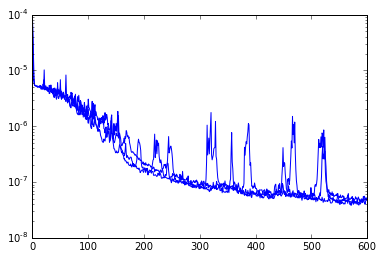

In [11]:
rs = tasks.result()
for i in range(3):
    train_x_current, train_y_current = zip(*rs[i])
    plt.plot(train_x_current, train_y_current, label="Current", color="blue")
plt.yscale('log')
plt.ylim([0.00000001, 0.0001]) 
plt.show()